# Test the Matern kernel and MCMC estimation

In [5]:
from oceanoi.oijax import OptimalInterpJax
import jax.scipy.stats as jstats
import jax.numpy as jnp
import jax

from oceanoi.mcmc_jax import mcmc_jax, mcmc_jax_debug, JaxPrior
from oceanoi import covjax 
from oceanoi import cov

import numpy as onp
import matplotlib.pyplot as plt

In [6]:
jax.config.update("jax_debug_nans", True) 

In [7]:
import jax.numpy as np
from jax.scipy.special import gammaln

def gamma(x):
    return np.exp(gammaln(x))

# Modified bessel function of the second kind
#https://github.com/google/jax/issues/9956

def phi(t):
    return np.exp(np.pi / 2 * np.sinh(t))

def dphi(t):
    return np.pi / 2 * np.cosh(t) * np.exp(np.pi / 2 * np.sinh(t))

def bessel_k(nu, z):
    
    z = np.asarray(z)[..., None]
    t = np.linspace(-3, 3, 101)[None, :]
    integrand = 0.5*(0.5*z)**nu*np.exp(-phi(t)-z**2/(4*phi(t)))*phi(t)**(-nu-1)*dphi(t)

    return np.trapz(integrand, x=t, axis=-1)

###
def matern_general(dx, eta, nu, l):
    
    cff1 = np.sqrt(2*nu)*dx/l
    K = np.power(eta, 2.) * np.power(2., 1-nu) / gamma(nu)
    K *= np.power(cff1, nu)
    K *= bessel_k(nu,cff1)
    #x = x.at[idx].set(y)
    idx = dx < 1e-6
    #idx = np.isnan(K)
    #return K.at[idx].set(np.power(eta, 2.))
    return np.where(idx, np.power(eta,2.), K)
    
    #return K
    
def matern_general_1d(x, xpr, params):
    eta, nu, l = params
    dx = np.sqrt((x-xpr)*(x-xpr))
    return matern_general(dx, eta, nu, l)


In [8]:
%%time
# np.random.seed(1) # this generates the same output every time
# Generate some training data

####
# Change these parameters here
noise = 0.1
η = 1.
ν = 0.5
ℓ = 100
covfunc = matern_general_1d
# covfunc = cov.matern_general_1d
# covfunc = covjax.matern32_1d

####

covparams = (η, ν, ℓ)
# covparams = (η, ℓ)

dx = 25.
N = 300

xd = onp.arange(0,dx*N,dx)
xo = onp.linspace(-10*dx,dx*N+dx*10,N*10)

# K = covfunc(xd[:,None], xd[:,None].T, covparams)
# mu = np.zeros_like(xd)
# yd = np.random.multivariate_normal(mu.ravel(), K, 1).ravel()
# yd += noise*np.random.normal(size=(N,))

myOI = OptimalInterpJax(xd[:,None], xd[:,None], noise, covfunc, covparams)
yd = myOI.prior(noise=0)

plt.figure()
plt.plot(xd, yd,'.')
dx, xd.shape

CPU times: user 611 ms, sys: 461 ms, total: 1.07 s
Wall time: 806 ms


(25.0, (300,))

In [ ]:
%%time
initvals = jnp.array([0.5, 5.,1.5, 20])
# initvals = jnp.array([0.5, 5., 20])

priors = [JaxPrior('norm', 0.1, 0.1 ),
         JaxPrior('norm', 1, 0.5), 
         JaxPrior('norm', 0.5, 0.2),
         #JaxPrior('invgamma', 2.),
         JaxPrior('norm', 100, 25),]

ncovparams = len(priors)  

states = mcmc_jax_debug(
    xd[:,None], yd, 
    covfunc, 
    None, 
    priors,
    ncovparams,
    mean_kwargs={},
    cov_kwargs={},
    #nwarmup=1000, 
    niter=5,
    oi_kwargs={},
    initvals=initvals,
    step_size=1e-3,
    inverse_mass_matrix=jnp.array([1., 1., 1., 1]))

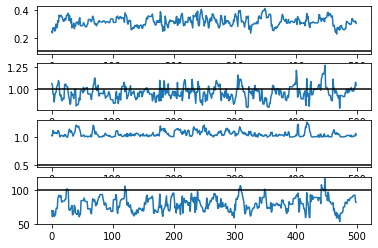

In [15]:
plt.figure()
plt.subplot(411)
plt.plot(states[0][:,0])
plt.axhline(noise,c='k')
# plt.axhline(-noise,c='k')

plt.subplot(412)
plt.plot(states[0][:,1])
plt.axhline(η,c='k')

plt.subplot(413)
plt.plot(states[0][:,2])
plt.axhline(ν,c='k')

plt.subplot(414)
plt.plot(states[0][:,3])
plt.axhline(ℓ,c='k')

# Use a slow sampler for debugging

In [6]:
import jax
import blackjax 

def mcmc_jax_debug(
    xd, yd, 
    covfunc, 
    meanfunc, 
    priors,
    ncovparams,
    mean_kwargs={},
    cov_kwargs={},
    niter=5,
    oi_kwargs={},
    step_size = 1e-3,
    inverse_mass_matrix=None,
    initvals = None):
    
    nparams = len(priors)
    
    def logprob_fn(params):

        noise = params[0]
        covparams = params[1:ncovparams]
        meanparams = params[ncovparams:]

        ## Add on the priors
        log_prior = jnp.array([P.logpdf(val) for P, val in zip(priors, params)])
        sum_prior = jnp.sum(log_prior)
        #sum_prior = 0.
        
        #if jnp.any(jnp.isinf(log_prior)):
        #    return -np.inf

        myOI = OptimalInterpJax(xd, xd, noise, covfunc, covparams, mean_func=meanfunc,
                            mean_params=meanparams, 
                            mean_kwargs=mean_kwargs, 
                            cov_kwargs=cov_kwargs,
                            **oi_kwargs)

        logp = myOI.log_marg_likelihood(yd)
        return logp + sum_prior
    
    # Build the kernel
    # Tunable
    if inverse_mass_matrix is None:
        inverse_mass_matrix = jnp.ones((nparams),) # Tunable
        
    nuts = blackjax.nuts(logprob_fn, step_size, inverse_mass_matrix)
    
    # Intialise and do the warmup
    if initvals is None:
        initvals = jnp.array([pp.rvs() for pp in priors])
    

    state = nuts.init(initvals)
    
    # Iterate
    rng_key = jax.random.PRNGKey(0)
    for _ in range(niter):
        _, rng_key = jax.random.split(rng_key)
        state, _ = nuts.step(rng_key, state)
        print(state)
    
    return state

In [11]:
initvals = jnp.array([0.5, 1.,1.0, 50])
# initvals = jnp.array([0.5, 5., 20])

priors = [JaxPrior('norm', 0.1, 0.1 ),
         JaxPrior('norm', 1, 0.5), 
         JaxPrior('norm', 0.5, 0.2),
         #JaxPrior('invgamma', 2.),
         JaxPrior('norm', 100, 25),]

ncovparams = len(priors)  

states = mcmc_jax_debug(
    xd[:,None], yd, 
    covfunc, 
    None, 
    priors,
    ncovparams,
    mean_kwargs={},
    cov_kwargs={},
    niter=5,
    oi_kwargs={},
    initvals=initvals,
    step_size=1e-3,
    inverse_mass_matrix=jnp.array([1., 1., 1., 0.1]))

HMCState(position=DeviceArray([ 0.5,  1. ,  1. , 50. ], dtype=float64), potential_energy=DeviceArray(343.60111016, dtype=float64), potential_energy_grad=DeviceArray([175.41570605,  68.4590491 ,  -8.75424838,  -1.06013393], dtype=float64))
HMCState(position=DeviceArray([ 0.49671769,  1.0047392 ,  1.00105237, 50.00009053], dtype=float64), potential_energy=DeviceArray(343.34392687, dtype=float64), potential_energy_grad=DeviceArray([174.40657996,  69.24596818,  -8.8857915 ,  -1.06755207], dtype=float64))
HMCState(position=DeviceArray([ 0.4797294 ,  0.97696313,  1.0008863 , 49.98959963], dtype=float64), potential_energy=DeviceArray(338.57321142, dtype=float64), potential_energy_grad=DeviceArray([169.45039273,  64.62579304,  -8.29343262,  -1.04393794], dtype=float64))
HMCState(position=DeviceArray([ 0.47975582,  0.97567121,  1.0000047 , 49.98958033], dtype=float64), potential_energy=DeviceArray(338.5016702, dtype=float64), potential_energy_grad=DeviceArray([169.45228079,  64.41274932,  -8.30

# Testing covariance functions below here...

In [1]:
import jax.numpy as np
from jax.scipy.special import gammaln

def gamma(x):
    return np.exp(gammaln(x))

# Modified bessel function of the second kind
#https://github.com/google/jax/issues/9956

def phi(t):
    return np.exp(np.pi / 2 * np.sinh(t))

def dphi(t):
    return np.pi / 2 * np.cosh(t) * np.exp(np.pi / 2 * np.sinh(t))

def bessel_k(nu, z):
    
    z = np.asarray(z)[..., None]
    t = np.linspace(-3, 3, 101)[None, :]
    integrand = 0.5*(0.5*z)**nu*np.exp(-phi(t)-z**2/(4*phi(t)))*phi(t)**(-nu-1)*dphi(t)

    return np.trapz(integrand, x=t, axis=-1)

###
def matern_general(dx, eta, nu, l):
    
    cff1 = np.sqrt(2*nu)*dx/l
    K0 = np.power(eta, 2.) * np.power(2., 1-nu) / gamma(nu)
    K = K0 * np.power(cff1, nu)
    K *= bessel_k(nu,cff1)
    #x = x.at[idx].set(y)
    idx = dx < 1e-6
    #idx = np.isnan(K)
    #return K.at[idx].set(np.power(eta, 2.))
    #return np.where(idx, np.power(eta,2.), K)
    
    return K

In [2]:
x = np.linspace(0,100,100)
l=5
plt.figure()
plt.plot(x, matern_general(x, 1.0, 1.5, l))
# plt.plot(x, covjax.matern32(0, x, l))
plt.plot(x, cov.matern32(0, x, l))
plt.plot(x, cov.matern_general(x, 1.0, 1.5, l))


NameError: name 'plt' is not defined

In [ ]:
# dK = jax.grad(matern_general)
# dK(x[0], 1.1, 1.5, l)
bessel_k(x[0],0.5)

In [ ]:
# dK = jax.grad(matern_general)
# dK(x[3], 1.1, 1.5, l)
np.power(0/l,0.5)